In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [5]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 22, 'n_layers': 2, 'dropout': 0.013875149619123436}


In [6]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [7]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [8]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, target_scaler=target_scaler):
        super(SimpleNN, self).__init__()
        self.target_scaler = target_scaler
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [9]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        1,489,664
│    └─Sequential: 2-1                   [1, 22]                   --
│    │    └─Linear: 3-1                  [1, 506]                  (500,940)
│    │    └─ReLU: 3-2                    [1, 506]                  --
│    │    └─Dropout: 3-3                 [1, 506]                  --
│    │    └─Linear: 3-4                  [1, 23]                   (11,661)
│    │    └─ReLU: 3-5                    [1, 23]                   --
│    │    └─Dropout: 3-6                 [1, 23]                   --
│    │    └─Linear: 3-7                  [1, 22]                   (528)
├─SimpleNN: 1-2                          [1, 1]                    --
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-8                  [1, 44]              

In [10]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [11]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.7019364833831787     │
│         test_mse          │    1.7019364833831787     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7019364833831787, 'test_mse': 1.7019364833831787}]

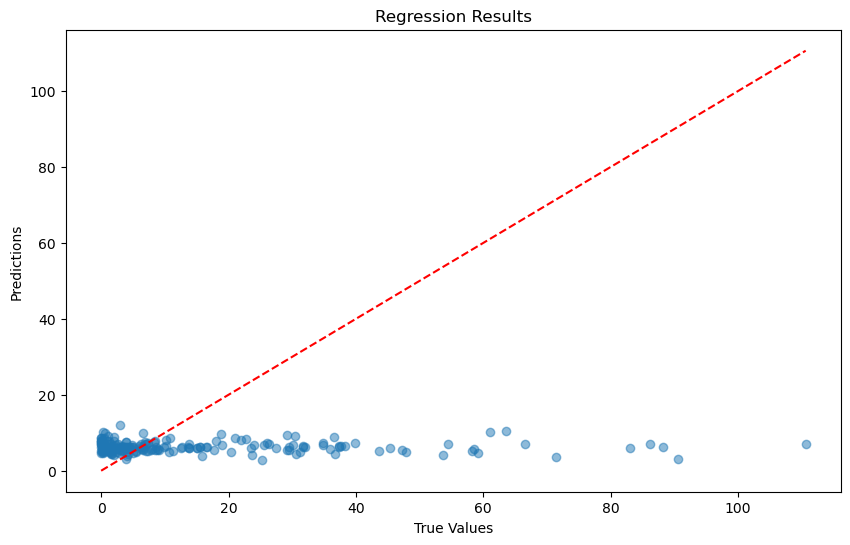

In [39]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.neural_network.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.neural_network.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cdm.test_dataloader())

In [13]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
            target_scaler=target_scaler,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [14]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="ae_regressor_scaled_study")
study.optimize(objective, n_trials=75, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 12:13:26,574] A new study created in memory with name: ae_regressor_scaled_study


  0%|          | 0/75 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:14:40,011] Trial 0 finished with value: 5.048385143280029 and parameters: {'n_layers': 12, 'dropout': 0.3778291912548763, 'learning_rate': 9.887367299267446e-05, 'weight_decay': 0.006229195524361334, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 0 with value: 5.048385143280029.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:15:05,459] Trial 1 finished with value: 7.690554618835449 and parameters: {'n_layers': 6, 'dropout': 0.384347594269772, 'learning_rate': 0.0002315428366963282, 'weight_decay': 1.6635326882592492e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 0 with value: 5.048385143280029.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:15:48,139] Trial 2 finished with value: 7.708648204803467 and parameters: {'n_layers': 7, 'dropout': 0.23248161634731274, 'learning_rate': 1.79401366823057e-05, 'weight_decay': 0.0007959938578322463, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 0 with value: 5.048385143280029.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:17:21,883] Trial 3 finished with value: 2.1018669605255127 and parameters: {'n_layers': 14, 'dropout': 0.06595400456323702, 'learning_rate': 0.0013761836161244323, 'weight_decay': 9.015349055859261e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 3 with value: 2.1018669605255127.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:18:17,235] Trial 4 finished with value: 5.883144378662109 and parameters: {'n_layers': 14, 'dropout': 0.3416387397351328, 'learning_rate': 0.0003947911515652649, 'weight_decay': 0.000129925083662587, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 3 with value: 2.1018669605255127.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:23:02,371] Trial 5 finished with value: 3.06769061088562 and parameters: {'n_layers': 15, 'dropout': 0.337753426980263, 'learning_rate': 0.00031624072236884754, 'weight_decay': 0.0063354716901784115, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 3 with value: 2.1018669605255127.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:23:32,882] Trial 6 finished with value: 6.009130954742432 and parameters: {'n_layers': 14, 'dropout': 0.07568968211154348, 'learning_rate': 0.0002833000834918905, 'weight_decay': 3.1831861414007556e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 2.1018669605255127.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:24:01,772] Trial 7 finished with value: 1.8076704740524288 and parameters: {'n_layers': 9, 'dropout': 0.21461976821511963, 'learning_rate': 0.006864735452631411, 'weight_decay': 0.0008341510937025956, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 7 with value: 1.8076704740524288.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:24:16,571] Trial 8 finished with value: 5.6863555908203125 and parameters: {'n_layers': 11, 'dropout': 0.038852778720320225, 'learning_rate': 3.539226595788043e-05, 'weight_decay': 0.0001839462111473747, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 7 with value: 1.8076704740524288.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:24:30,666] Trial 9 finished with value: 5.843658924102783 and parameters: {'n_layers': 3, 'dropout': 0.16074906107977432, 'learning_rate': 5.903280486177691e-05, 'weight_decay': 0.0014414034634927229, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 7 with value: 1.8076704740524288.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:26:05,779] Trial 10 finished with value: 1.7158091068267822 and parameters: {'n_layers': 9, 'dropout': 0.4585061363579688, 'learning_rate': 0.008864885814720842, 'weight_decay': 0.0012395659391381242, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 10 with value: 1.7158091068267822.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:26:51,677] Trial 11 finished with value: 1.7476282119750977 and parameters: {'n_layers': 9, 'dropout': 0.49515081070624906, 'learning_rate': 0.009917400557394514, 'weight_decay': 0.0010782292067589379, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 10 with value: 1.7158091068267822.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:27:49,362] Trial 12 finished with value: 1.710067868232727 and parameters: {'n_layers': 9, 'dropout': 0.47746763644451384, 'learning_rate': 0.009671069997171015, 'weight_decay': 0.001872498520395032, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:28:23,221] Trial 13 finished with value: 2.047767639160156 and parameters: {'n_layers': 7, 'dropout': 0.499008130651606, 'learning_rate': 0.003249701448402014, 'weight_decay': 0.0029144078760992365, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:29:59,929] Trial 14 finished with value: 1.87413227558136 and parameters: {'n_layers': 11, 'dropout': 0.4448473211372507, 'learning_rate': 0.0016229057758651122, 'weight_decay': 0.0003431780323800215, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:30:48,681] Trial 15 finished with value: 1.9001333713531492 and parameters: {'n_layers': 5, 'dropout': 0.2956693748476657, 'learning_rate': 0.00367281982863956, 'weight_decay': 0.002440625910819022, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:31:31,881] Trial 16 finished with value: 2.2159416675567627 and parameters: {'n_layers': 10, 'dropout': 0.43994270549009906, 'learning_rate': 0.0014697478127482914, 'weight_decay': 0.00045115187000420285, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:32:14,044] Trial 17 finished with value: 1.8934767246246336 and parameters: {'n_layers': 8, 'dropout': 0.4289853693814667, 'learning_rate': 0.004267731565454115, 'weight_decay': 0.002931642090923032, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:34:02,732] Trial 18 finished with value: 1.9760187864303589 and parameters: {'n_layers': 12, 'dropout': 0.2940840512050932, 'learning_rate': 0.0007288352989811706, 'weight_decay': 0.009695898568414863, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:34:32,239] Trial 19 finished with value: 1.9006072282791135 and parameters: {'n_layers': 4, 'dropout': 0.40428438576184583, 'learning_rate': 0.009589841495777681, 'weight_decay': 6.130559890332798e-05, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:35:20,383] Trial 20 finished with value: 2.1125056743621826 and parameters: {'n_layers': 8, 'dropout': 0.4713479163755051, 'learning_rate': 0.002201989001374054, 'weight_decay': 0.0021307483423646527, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 12 with value: 1.710067868232727.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:36:05,920] Trial 21 finished with value: 1.7047804594039917 and parameters: {'n_layers': 9, 'dropout': 0.49292292753944333, 'learning_rate': 0.009721542472292483, 'weight_decay': 0.0009506058664907911, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:37:28,548] Trial 22 finished with value: 1.803420662879944 and parameters: {'n_layers': 10, 'dropout': 0.44718629898310785, 'learning_rate': 0.005255173640769504, 'weight_decay': 0.00039146554914113813, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:38:22,958] Trial 23 finished with value: 1.7915024757385254 and parameters: {'n_layers': 9, 'dropout': 0.356237250386951, 'learning_rate': 0.006049483282763549, 'weight_decay': 0.0006063275948317016, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:39:22,186] Trial 24 finished with value: 1.743247389793396 and parameters: {'n_layers': 8, 'dropout': 0.4982676169954122, 'learning_rate': 0.002697864268846261, 'weight_decay': 0.0017891668188824835, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:39:51,305] Trial 25 finished with value: 1.774431824684143 and parameters: {'n_layers': 6, 'dropout': 0.42202321736780335, 'learning_rate': 0.007585584068954537, 'weight_decay': 0.0002145605776770722, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:40:54,260] Trial 26 finished with value: 1.985869646072388 and parameters: {'n_layers': 10, 'dropout': 0.30081711414175816, 'learning_rate': 0.000905908770416218, 'weight_decay': 0.003662143899757016, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:41:34,219] Trial 27 finished with value: 1.7598004341125488 and parameters: {'n_layers': 12, 'dropout': 0.18315900545152508, 'learning_rate': 0.004535702666896465, 'weight_decay': 0.0012376555092874937, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:42:16,156] Trial 28 finished with value: 6.147153854370117 and parameters: {'n_layers': 7, 'dropout': 0.4684280608005795, 'learning_rate': 1.033436458823006e-05, 'weight_decay': 0.004228707186192827, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:42:27,380] Trial 29 finished with value: 7.205117702484131 and parameters: {'n_layers': 11, 'dropout': 0.3769024266344501, 'learning_rate': 0.00016102241627884565, 'weight_decay': 0.006304021325963154, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:42:59,860] Trial 30 finished with value: 4.142794132232666 and parameters: {'n_layers': 13, 'dropout': 0.3947044457479291, 'learning_rate': 0.0005762056647767438, 'weight_decay': 0.0007066559073609697, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:43:33,993] Trial 31 finished with value: 2.094851016998291 and parameters: {'n_layers': 8, 'dropout': 0.4991760313737268, 'learning_rate': 0.002342607820073368, 'weight_decay': 0.0015572140038334781, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:44:03,026] Trial 32 finished with value: 1.7726123332977295 and parameters: {'n_layers': 8, 'dropout': 0.46485029234912106, 'learning_rate': 0.0027470375854423005, 'weight_decay': 0.0018750603541936542, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:44:25,057] Trial 33 finished with value: 1.7126457691192627 and parameters: {'n_layers': 6, 'dropout': 0.4107522337934831, 'learning_rate': 0.005967536681311018, 'weight_decay': 0.0013209896759861762, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 21 with value: 1.7047804594039917.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:45:50,485] Trial 34 finished with value: 1.6829124689102173 and parameters: {'n_layers': 6, 'dropout': 0.4094772738135338, 'learning_rate': 0.00987682515320866, 'weight_decay': 1.0103946306777914e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 34 with value: 1.6829124689102173.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:51:56,433] Trial 35 finished with value: 1.7864007949829102 and parameters: {'n_layers': 5, 'dropout': 0.3724372134349785, 'learning_rate': 0.0059076370773263965, 'weight_decay': 1.4619602012725982e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 34 with value: 1.6829124689102173.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.


[I 2025-04-18 12:56:07,378] Trial 36 finished with value: 1.9277076721191408 and parameters: {'n_layers': 6, 'dropout': 0.41252536205807727, 'learning_rate': 0.0043577590275660424, 'weight_decay': 1.0207666380815025e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 34 with value: 1.6829124689102173.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:58:04,380] Trial 37 finished with value: 1.6518620252609253 and parameters: {'n_layers': 5, 'dropout': 0.32849231528302264, 'learning_rate': 0.009732385610585552, 'weight_decay': 3.3541208705881336e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:00:22,420] Trial 38 finished with value: 1.7045842409133911 and parameters: {'n_layers': 3, 'dropout': 0.3167931591642892, 'learning_rate': 0.00990089418182588, 'weight_decay': 3.286760445689817e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:00:46,510] Trial 39 finished with value: 6.15835428237915 and parameters: {'n_layers': 3, 'dropout': 0.3241560801985758, 'learning_rate': 0.00011837766869455327, 'weight_decay': 3.337008128591368e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:01:22,674] Trial 40 finished with value: 5.338724613189697 and parameters: {'n_layers': 4, 'dropout': 0.260615982804126, 'learning_rate': 0.0016862031163887234, 'weight_decay': 2.968009178253894e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:03:38,597] Trial 41 finished with value: 1.6930197477340698 and parameters: {'n_layers': 4, 'dropout': 0.333029336733205, 'learning_rate': 0.007617078623433135, 'weight_decay': 5.382818170522954e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:05:46,106] Trial 42 finished with value: 1.8428823947906492 and parameters: {'n_layers': 4, 'dropout': 0.2555746872247651, 'learning_rate': 0.007021704038144007, 'weight_decay': 6.83813740718934e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:11:20,686] Trial 43 finished with value: 1.7445793151855469 and parameters: {'n_layers': 5, 'dropout': 0.3238332762194749, 'learning_rate': 0.0076871946530390305, 'weight_decay': 2.3730146482745138e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:12:28,056] Trial 44 finished with value: 5.540438175201416 and parameters: {'n_layers': 3, 'dropout': 0.355189285515253, 'learning_rate': 0.0035870348590844666, 'weight_decay': 5.077709027631069e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:16:13,013] Trial 45 finished with value: 1.8099308013916016 and parameters: {'n_layers': 4, 'dropout': 0.3184025614972927, 'learning_rate': 0.005166253506897278, 'weight_decay': 0.00010611778699657383, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:19:25,016] Trial 46 finished with value: 1.702692627906799 and parameters: {'n_layers': 3, 'dropout': 0.2793177594454608, 'learning_rate': 0.009338612307935729, 'weight_decay': 1.9716550569745165e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:20:03,462] Trial 47 finished with value: 5.544414043426514 and parameters: {'n_layers': 3, 'dropout': 0.27278462092729966, 'learning_rate': 3.705349001571322e-05, 'weight_decay': 1.7133121569690224e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:20:38,168] Trial 48 finished with value: 5.681731700897217 and parameters: {'n_layers': 5, 'dropout': 0.24030193541678854, 'learning_rate': 0.001042550393303761, 'weight_decay': 4.184545594286306e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:23:22,124] Trial 49 finished with value: 1.831187605857849 and parameters: {'n_layers': 4, 'dropout': 0.20047177518353385, 'learning_rate': 0.007451725503932795, 'weight_decay': 1.7294284056210134e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:24:21,023] Trial 50 finished with value: 1.6813336610794067 and parameters: {'n_layers': 3, 'dropout': 0.27473584007634777, 'learning_rate': 0.0030805945689549273, 'weight_decay': 1.0570141424342488e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:25:41,451] Trial 51 finished with value: 1.6643019914627075 and parameters: {'n_layers': 3, 'dropout': 0.27953509236613133, 'learning_rate': 0.003416049630303505, 'weight_decay': 1.26365325406496e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:26:39,167] Trial 52 finished with value: 1.6783273220062256 and parameters: {'n_layers': 3, 'dropout': 0.21957054729084474, 'learning_rate': 0.0044018867578506605, 'weight_decay': 1.0007773416668812e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:27:51,720] Trial 53 finished with value: 1.6954350471496582 and parameters: {'n_layers': 4, 'dropout': 0.13362416816583175, 'learning_rate': 0.0033309365729394195, 'weight_decay': 1.0844408016548402e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:29:23,504] Trial 54 finished with value: 1.692733883857727 and parameters: {'n_layers': 5, 'dropout': 0.22782170367041488, 'learning_rate': 0.0021490778305601364, 'weight_decay': 1.267015793660545e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:31:01,030] Trial 55 finished with value: 1.6812334060668943 and parameters: {'n_layers': 5, 'dropout': 0.2242455262438048, 'learning_rate': 0.001932151055621367, 'weight_decay': 1.2942084185887762e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:36:13,798] Trial 56 finished with value: 1.7121028900146484 and parameters: {'n_layers': 6, 'dropout': 0.14121985831062595, 'learning_rate': 0.001330072002395985, 'weight_decay': 2.259650354086613e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:40:33,809] Trial 57 finished with value: 1.805872082710266 and parameters: {'n_layers': 5, 'dropout': 0.20886607851876562, 'learning_rate': 0.0005216176900736085, 'weight_decay': 1.2942549310278883e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:41:30,532] Trial 58 finished with value: 1.791001319885254 and parameters: {'n_layers': 3, 'dropout': 0.17950095368000013, 'learning_rate': 0.0037278729336447333, 'weight_decay': 1.0422798125712075e-05, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:43:28,187] Trial 59 finished with value: 1.6945420503616333 and parameters: {'n_layers': 7, 'dropout': 0.2236811352578461, 'learning_rate': 0.0020136897731423504, 'weight_decay': 2.4120977937776995e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:44:16,254] Trial 60 finished with value: 1.8978214263916016 and parameters: {'n_layers': 6, 'dropout': 0.2438805821856241, 'learning_rate': 0.0027642742924606483, 'weight_decay': 1.375621960306995e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:46:26,343] Trial 61 finished with value: 1.6920467615127563 and parameters: {'n_layers': 5, 'dropout': 0.23156826197236133, 'learning_rate': 0.0019332741223875947, 'weight_decay': 1.2980322962090083e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:49:00,807] Trial 62 finished with value: 1.7051308155059814 and parameters: {'n_layers': 4, 'dropout': 0.2835162426650725, 'learning_rate': 0.0011566719758773466, 'weight_decay': 1.7389657176233512e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:51:05,624] Trial 63 finished with value: 1.6863694190979004 and parameters: {'n_layers': 5, 'dropout': 0.1916470422156839, 'learning_rate': 0.0017244996607592156, 'weight_decay': 1.4029405630378293e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:51:57,074] Trial 64 finished with value: 1.793321967124939 and parameters: {'n_layers': 3, 'dropout': 0.11233314329660485, 'learning_rate': 0.004809363770796596, 'weight_decay': 2.803140503117688e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:53:32,551] Trial 65 finished with value: 1.6859374046325684 and parameters: {'n_layers': 7, 'dropout': 0.18528576056944257, 'learning_rate': 0.0029291225040064734, 'weight_decay': 1.9775284980799568e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:54:40,463] Trial 66 finished with value: 1.719531536102295 and parameters: {'n_layers': 7, 'dropout': 0.15809908455557184, 'learning_rate': 0.002990333038391258, 'weight_decay': 2.104307997225063e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:55:25,237] Trial 67 finished with value: 1.818852543830872 and parameters: {'n_layers': 6, 'dropout': 0.2679690643082039, 'learning_rate': 0.003963009467642365, 'weight_decay': 3.7626293489598796e-05, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:55:55,605] Trial 68 finished with value: 1.9085575342178345 and parameters: {'n_layers': 7, 'dropout': 0.018037912101574294, 'learning_rate': 0.0057658433748762235, 'weight_decay': 1.7053546573321258e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.


[I 2025-04-18 14:00:27,689] Trial 69 finished with value: 1.972275972366333 and parameters: {'n_layers': 4, 'dropout': 0.3000042273692485, 'learning_rate': 0.0003655817830370176, 'weight_decay': 1.0044401162814184e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:03:33,513] Trial 70 finished with value: 1.7862975597381592 and parameters: {'n_layers': 6, 'dropout': 0.21259636725042402, 'learning_rate': 0.0007484432067321889, 'weight_decay': 0.00018558515470349342, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:06:14,731] Trial 71 finished with value: 1.6724919080734253 and parameters: {'n_layers': 5, 'dropout': 0.18838999512602345, 'learning_rate': 0.0014734683544046286, 'weight_decay': 1.3841916198728626e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:07:39,599] Trial 72 finished with value: 1.702908635139465 and parameters: {'n_layers': 5, 'dropout': 0.17310328811435116, 'learning_rate': 0.002481737296000084, 'weight_decay': 2.5724056337282292e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:09:06,897] Trial 73 finished with value: 1.678333401679993 and parameters: {'n_layers': 3, 'dropout': 0.24963464763846893, 'learning_rate': 0.003205769139698487, 'weight_decay': 1.2218108906050148e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:11:29,225] Trial 74 finished with value: 1.6974564790725708 and parameters: {'n_layers': 3, 'dropout': 0.24936540677843338, 'learning_rate': 0.0013753882369392794, 'weight_decay': 1.168977573686845e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 37 with value: 1.6518620252609253.
Best trial:
  Value (val_mse): 1.6518620252609253
  Params:
    n_layers: 5
    dropout: 0.32849231528302264
    learning_rate: 0.009732385610585552
    weight_decay: 3.3541208705881336e-05
    optimizer: adagrad
    activation: tanh


In [15]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

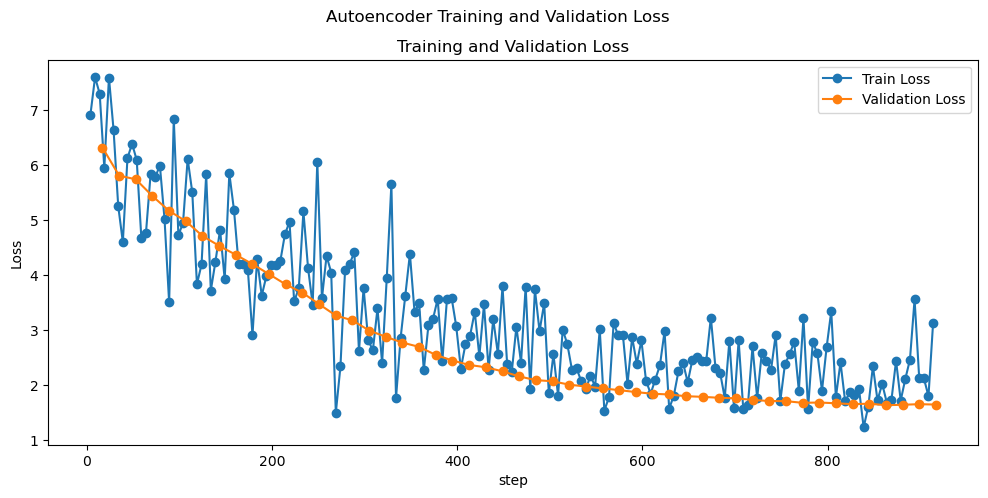

In [16]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [17]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/05/best_model.pth

In [18]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
            target_scaler=target_scaler,
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=989, out_features=506, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.013875149619123436, inplace=False)
      (3): Linear(in_features=506, out_features=23, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.013875149619123436, inplace=False)
      (6): Linear(in_features=23, out_features=22, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=22, out_features=505, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.013875149619123436, inplace=False)
      (3): Linear(in_features=505, out_features=988, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.013875149619123436, inplace=False)
      (6): Linear(in_features=988, out_features=989, bias=True)
    )
    (loss_metric): MeanSquaredError()
    (val_metric): MeanSquaredError()
    (test_metric): MeanSquaredError()
  )
  (neural_network): SimpleNN(
    (network): Sequential(
      (0): Lin

In [ ]:
# trainer2, regressor_csv_logger2, regressor_checkpoint2 = create_classifier_trainer("cancer_regressor", max_epochs=50, allow_early_stop=False)
# trainer2.fit(
#     model=best_model,
#     datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
# )

In [ ]:
# history = pd.read_csv(regressor_csv_logger2.log_dir + "/metrics.csv")
# make_plots(history, "Autoencoder Training and Validation Loss")

In [19]:
joblib.dump(
    best_model,
    f"results/05/best_model_trial_ae_scaled_{study.best_trial.number}.pkl",
)

['results/05/best_model_trial_ae_scaled_37.pkl']

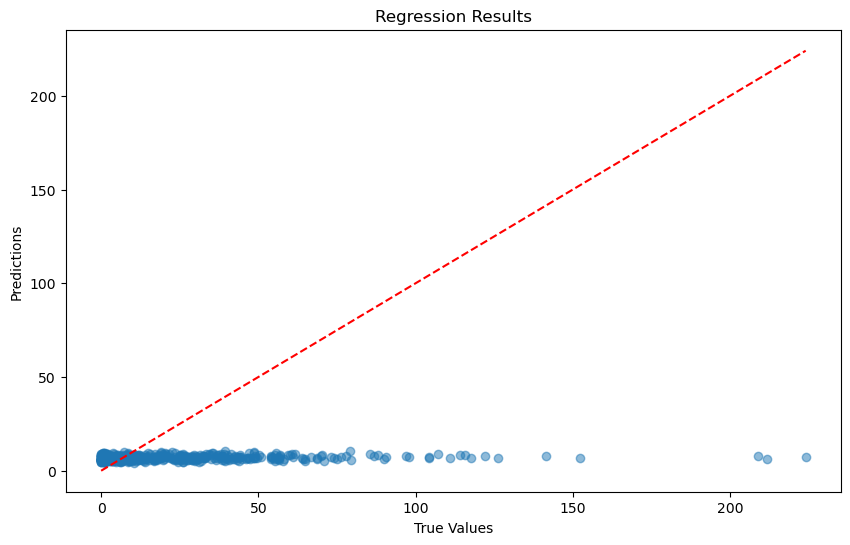

In [40]:
plot_regression_results(best_model.to("cpu"), cdm.train_dataloader())

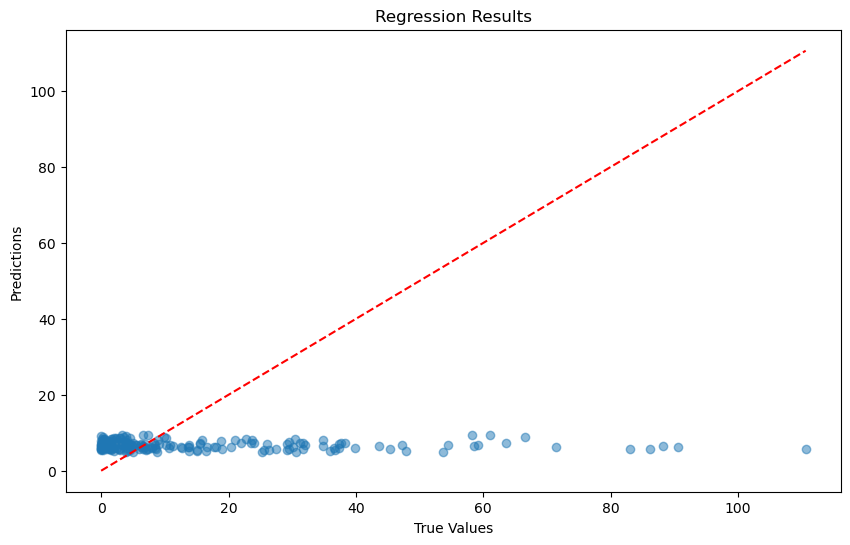

In [41]:
plot_regression_results(best_model.to("cpu"), cdm.test_dataloader())

In [36]:
#get first x, y from test loader
x, y = next(iter(cancer_dm.test_dataloader()))
x = x.to("cpu")
y = y.to("cpu")
print(y)

tensor([[1.5500e+00],
        [2.9500e+01],
        [6.2200e+00],
        [3.7340e+01],
        [3.3000e+00],
        [2.3450e+01],
        [3.0000e-02],
        [1.0820e+01],
        [2.7300e+00],
        [1.8060e+01],
        [3.4770e+01],
        [1.1350e+01],
        [6.9700e+00],
        [4.9700e+00],
        [8.0300e+00],
        [8.4900e+00],
        [1.5000e+00],
        [3.2000e+00],
        [2.5000e+00],
        [1.4500e+00],
        [3.0360e+01],
        [5.4000e+00],
        [1.1200e+00],
        [3.7700e+01],
        [1.9700e+00],
        [5.0000e-01],
        [3.0300e+00],
        [1.3800e+01],
        [2.6000e+01],
        [4.5400e+00],
        [1.0200e+00],
        [4.0000e+00]])
